# ベイジアン線形回帰

In [1]:
import logging
import os
from functools import partial

import torch
from torch import nn
from torch.distributions import constraints

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pyro
import pyro.distributions as dist

pyro.enable_validation(True)
pyro.set_rng_seed(1)
pyro.enable_validation(True)

%matplotlib inline
plt.style.use('default')

## データ

In [2]:
DATA_URL = "https://d2hg8soec8ck9v.cloudfront.net/datasets/rugged_data.csv"

data = pd.read_csv(DATA_URL, encoding="ISO-8859-1")
df = data[["cont_africa", "rugged", "rgdppc_2000"]]
df = df[np.isfinite(df.rgdppc_2000)]
df["rgdppc_2000"] = np.log(df["rgdppc_2000"])

train = torch.tensor(df.values, dtype=torch.float)

## Pyroによるベイジアン線形回帰

### モデル(Model)

$$
y \sim {\mathcal N}(wX +a, \sigma) \\
w = [{\rm b_A}, {\rm b_R}, {\rm b_{AR}}] \\
\sigma \sim {\rm Uni}(0, 10)
$$

事前分布
$$
{\rm b_A}, {\rm b_R}, {\rm b_{AR}} \sim {\mathcal N}(0, 1) \\
a_0 \sim {\mathcal N}(0, 10)
$$

### 近似分布(Guide)

$$
{\rm b_A}, {\rm b_R}, {\rm b_{AR}} \sim {\mathcal N}(w_{loc}, w_{scale}) \\
a \sim {\mathcal N}(a_{loc}, a_{scale})
$$

ハイパーパラメータ

$$
a_{loc}, a_{scale} = 0, 1 \ \ \ \ (a_{scale} > 0) \\
\sigma_{loc}, \sigma_{scale} = 1, 0.05 \\
w_{loc}, w_{scale} = {\rm Rand}(0, 1), 1
$$

In [3]:
class BayesianRegression(nn.Module):
    def __init__(self):
        super().__init__()
    
    def model(self, is_cont_africa, ruggedness, log_gdp):
        a = pyro.sample("a", dist.Normal(0., 10.))

        b_a = pyro.sample("bA", dist.Normal(0., 1.))
        b_r = pyro.sample("bR", dist.Normal(0., 1.))
        b_ar = pyro.sample("bAR", dist.Normal(0., 1.))
        
        sigma = pyro.sample("sigma", dist.Uniform(0., 10.))
        mean = b_a * is_cont_africa \
                      + b_r * ruggedness \
                      + b_ar * (is_cont_africa * ruggedness) \
                      + a
        
        with pyro.plate("data", len(ruggedness)):
            pyro.sample("obs", dist.Normal(mean, sigma), obs=log_gdp)
    
    def guide(self, is_cont_africa, ruggedness, log_gdp):
        # NOTE: locってなんの略称？
        a_loc = pyro.param("a_loc", torch.tensor(0.))
        a_scale = pyro.param("a_scale", torch.tensor(1.), constraint=constraints.positive)
        
        # NOTE: sigma_scaleは追跡しない理由は？
        sigma_loc = pyro.param("sigma_loc", torch.tensor(1.), constraint=constraints.positive)
        
        weights_loc = pyro.param("weights_loc", torch.randn(3))
        weights_scale = pyro.param("weights_scale", torch.ones(3), constraint=constraints.positive)
        
        a = pyro.sample("a", dist.Normal(a_loc, a_scale))
        b_a = pyro.sample("bA", dist.Normal(weights_loc[0], weights_scale[0]))
        b_r = pyro.sample("bR", dist.Normal(weights_loc[1], weights_scale[1]))
        b_ar = pyro.sample("bAR", dist.Normal(weights_loc[2], weights_scale[2]))
        sigma = pyro.sample("sigma", dist.Normal(sigma_loc, torch.tensor(0.05)))
        mean = b_a * is_cont_africa \
                      + b_r * ruggedness \
                      + b_ar * (is_cont_africa * ruggedness) \
                      + a

In [4]:
def summary(samples):
    site_stats = {}
    for site_name, values in samples.items():
        marginal_site = pd.DataFrame(values)
        describe = marginal_site.describe(percentiles=[.05, 0.25, 0.5, 0.75, 0.95]).transpose()
        site_stats[site_name] = describe[["mean", "std", "5%", "25%", "50%", "75%", "95%"]]
    return site_stats

## SVIによる学習

In [5]:
from pyro.infer import SVI, Trace_ELBO

br = BayesianRegression()
svi = SVI(br.model,
                br.guide,
                pyro.optim.Adam({"lr": .05}),
                loss=Trace_ELBO())

is_cont_africa, ruggedness, log_gdp = train[:, 0], train[:, 1], train[:, 2]
pyro.clear_param_store()
num_iters = 5000

for i in range(num_iters):
    elbo = svi.step(is_cont_africa, ruggedness, log_gdp)
    if i % 500 == 0:
        print("Elbo loss: {}".format(elbo))

Elbo loss: 5795.467590510845
Elbo loss: 415.8169445991516
Elbo loss: 250.71916341781616
Elbo loss: 247.19457256793976
Elbo loss: 249.20040410757065
Elbo loss: 250.9648449420929
Elbo loss: 249.35092562437057
Elbo loss: 248.78315633535385
Elbo loss: 248.62143635749817
Elbo loss: 250.42744302749634


In [6]:
from pyro.infer import Predictive

num_samples = 1000
predictive = Predictive(br.model, guide=br.guide, num_samples=num_samples)
svi_samples = {k: v.reshape(num_samples).detach().cpu().numpy()
               for k, v in predictive(log_gdp, is_cont_africa, ruggedness).items()
               if k != "obs"}

In [7]:
for site, values in summary(svi_samples).items():
    print("Site: {}".format(site))
    print(values, "\n")

Site: a
       mean       std        5%       25%      50%       75%       95%
0  9.177024  0.059607  9.078109  9.140462  9.17821  9.217097  9.271518 

Site: bA
       mean       std        5%       25%       50%       75%       95%
0 -1.890622  0.122805 -2.088489 -1.979106 -1.887476 -1.803683 -1.700853 

Site: bR
       mean       std       5%       25%       50%       75%       95%
0 -0.157847  0.039538 -0.22324 -0.183672 -0.157872 -0.133102 -0.091713 

Site: bAR
       mean       std        5%       25%       50%       75%       95%
0  0.304515  0.067683  0.194583  0.259464  0.304908  0.348932  0.415128 

Site: sigma
       mean       std        5%       25%       50%       75%       95%
0  0.902898  0.047971  0.824166  0.870317  0.901981  0.935171  0.981577 



## HMCによる学習

In [8]:
from pyro.infer import MCMC, NUTS

# NOTE: 中でどういう動きが起きてるのかさっぱり分からない
nuts_kernel = NUTS(br.model)

mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=200)
mcmc.run(is_cont_africa, ruggedness, log_gdp)

hmc_samples = {k: v.detach().cpu().numpy() for k, v in mcmc.get_samples().items()}

Sample: 100%|██████████| 1200/1200 [01:03, 18.77it/s, step size=3.99e-01, acc. prob=0.924]


In [9]:
for site, values in summary(hmc_samples).items():
    print("Site: {}".format(site))
    print(values, "\n")

Site: a
      mean       std        5%       25%       50%       75%       95%
0  9.18423  0.136175  8.965023  9.089115  9.183091  9.276202  9.409942 

Site: bA
       mean       std        5%      25%       50%       75%       95%
0 -1.842419  0.225592 -2.191255 -1.99521 -1.850966 -1.701606 -1.457616 

Site: bR
       mean       std        5%       25%       50%      75%       95%
0 -0.184282  0.077765 -0.320553 -0.235859 -0.184664 -0.13057 -0.059391 

Site: bAR
       mean       std        5%       25%       50%       75%       95%
0  0.345258  0.129194  0.132693  0.257868  0.343274  0.436686  0.552036 

Site: sigma
       mean      std        5%       25%       50%       75%       95%
0  0.948801  0.05325  0.866221  0.911891  0.947392  0.984085  1.037384 



## SVIとHMCの事後分布の比較

 HMCに比べてSVIでのパラメータの事後分布は分散が小さい
- ${\rm KL}[p||q]$の最小化の結果
- これは多次元ガウス分布の共分散行列が対角行列のため、潜在変数缶の相関を扱うことが出来なかったから

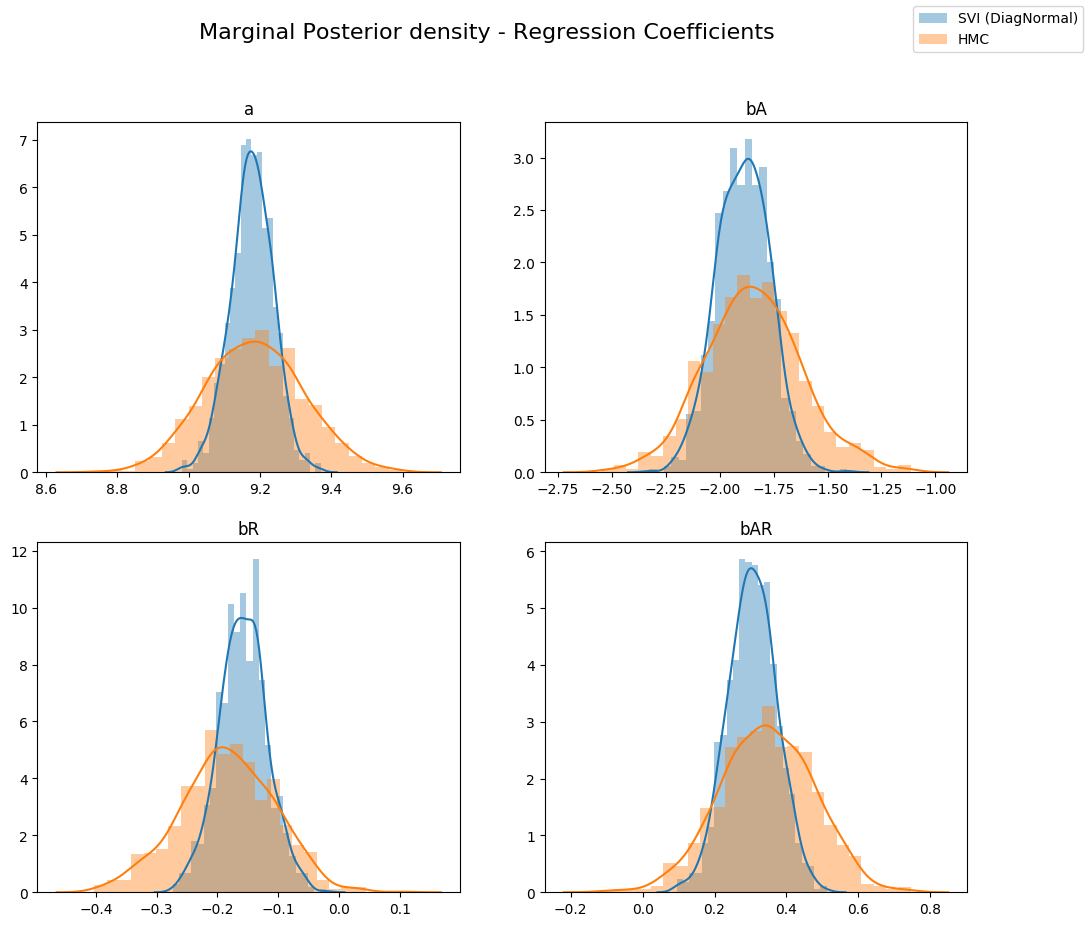

In [10]:
sites = ["a", "bA", "bR", "bAR", "sigma"]

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
fig.suptitle("Marginal Posterior density - Regression Coefficients", fontsize=16)
for i, ax in enumerate(axs.reshape(-1)):
    site = sites[i]
    sns.distplot(svi_samples[site], ax=ax, label="SVI (DiagNormal)")
    sns.distplot(hmc_samples[site], ax=ax, label="HMC")
    ax.set_title(site)
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right');

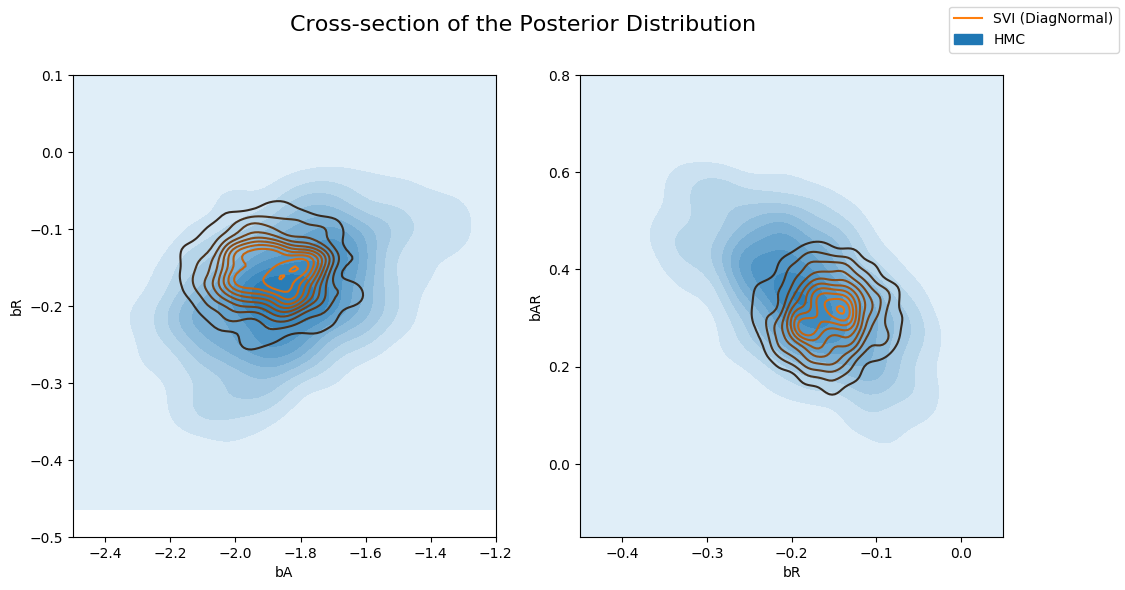

In [11]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
fig.suptitle("Cross-section of the Posterior Distribution", fontsize=16)
sns.kdeplot(hmc_samples["bA"], hmc_samples["bR"], ax=axs[0], shade=True, label="HMC")
sns.kdeplot(svi_samples["bA"], svi_samples["bR"], ax=axs[0], label="SVI (DiagNormal)")
axs[0].set(xlabel="bA", ylabel="bR", xlim=(-2.5, -1.2), ylim=(-0.5, 0.1))
sns.kdeplot(hmc_samples["bR"], hmc_samples["bAR"], ax=axs[1], shade=True, label="HMC")
sns.kdeplot(svi_samples["bR"], svi_samples["bAR"], ax=axs[1], label="SVI (DiagNormal)")
axs[1].set(xlabel="bR", ylabel="bAR", xlim=(-0.45, 0.05), ylim=(-0.15, 0.8))
handles, labels = axs[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right');

## MultivariateNormal Guide

モデル内の観測されていないデータのパラメータに対して、対角行列を仮定しない多次元ガウス分布を仮定した近似分布での実験

In [12]:
from pyro.infer.autoguide import AutoMultivariateNormal, init_to_mean

from pyro.infer.autoguide import AutoMultivariateNormal, init_to_mean


br = BayesianRegression()

auto_multi_guide = AutoMultivariateNormal(br.model, init_loc_fn=init_to_mean)

svi = SVI(br.model,
          auto_multi_guide,
          pyro.optim.Adam({"lr": .01}),
          loss=Trace_ELBO())

is_cont_africa, ruggedness, log_gdp = train[:, 0], train[:, 1], train[:, 2]
pyro.clear_param_store()
for i in range(num_iters):
    elbo = svi.step(is_cont_africa, ruggedness, log_gdp)
    if i % 500 == 0:
        print("Elbo loss: {}".format(elbo))

Elbo loss: 700.3803762793541
Elbo loss: 439.90814781188965
Elbo loss: 250.66882181167603
Elbo loss: 246.57109773159027
Elbo loss: 249.50567919015884
Elbo loss: 248.6053844690323
Elbo loss: 247.5673017501831
Elbo loss: 247.53627806901932
Elbo loss: 246.4845793247223
Elbo loss: 247.88326209783554


## MultivariateNormal Guideを利用したSVIとHMCの事後分布の比較

真の事後分布であるHMCに近い！

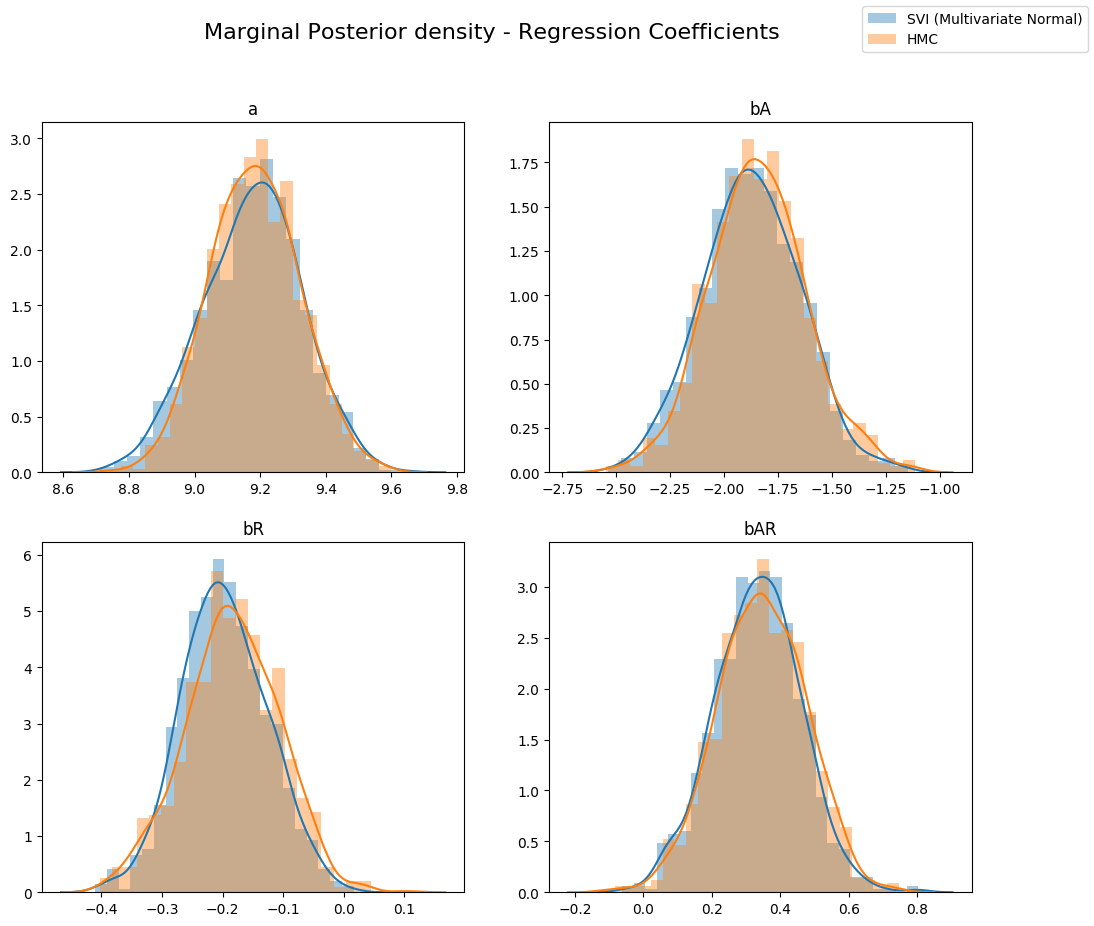

In [13]:
predictive = Predictive(br.model, guide=auto_multi_guide, num_samples=num_samples)
svi_mvn_samples = {k: v.reshape(num_samples).detach().cpu().numpy()
                   for k, v in predictive(log_gdp, is_cont_africa, ruggedness).items()
                   if k != "obs"}
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
fig.suptitle("Marginal Posterior density - Regression Coefficients", fontsize=16)
for i, ax in enumerate(axs.reshape(-1)):
    site = sites[i]
    sns.distplot(svi_mvn_samples[site], ax=ax, label="SVI (Multivariate Normal)")
    sns.distplot(hmc_samples[site], ax=ax, label="HMC")
    ax.set_title(site)
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right');

## MultivariateNormal GuideとDiagonalNormal Guideの比較

NOTE: ここらへんからチュートリアル怪しい。labelが一致してないので

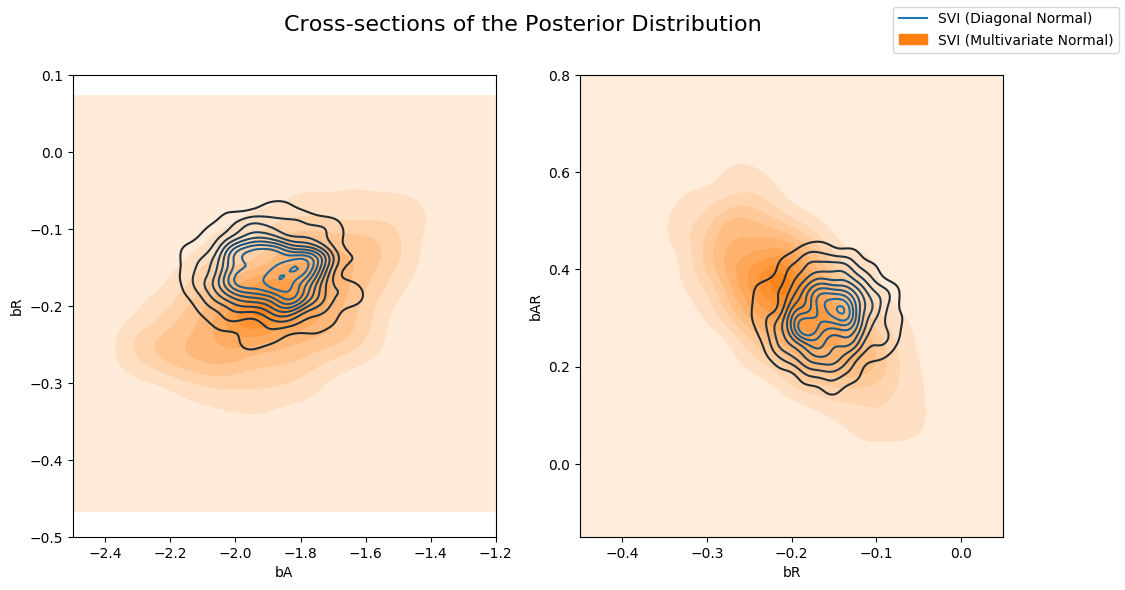

In [16]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
fig.suptitle("Cross-sections of the Posterior Distribution", fontsize=16)

sns.kdeplot(svi_samples["bA"], svi_samples["bR"], ax=axs[0], label="SVI (Diagonal Normal)")
sns.kdeplot(svi_mvn_samples["bA"], svi_mvn_samples["bR"], ax=axs[0], shade=True, label="SVI (Multivariate Normal)")
axs[0].set(xlabel="bA", ylabel="bR", xlim=(-2.5, -1.2), ylim=(-0.5, 0.1))

sns.kdeplot(svi_samples["bR"], svi_samples["bAR"], ax=axs[1], label="SVI (Diagonal Normal)")
sns.kdeplot(svi_mvn_samples["bR"], svi_mvn_samples["bAR"], ax=axs[1], shade=True, label="SVI (Multivariate Normal)")
axs[1].set(xlabel="bR", ylabel="bAR", xlim=(-0.45, 0.05), ylim=(-0.15, 0.8))

handles, labels = axs[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right');

## MultivariateNormal GuideとHMCの比較

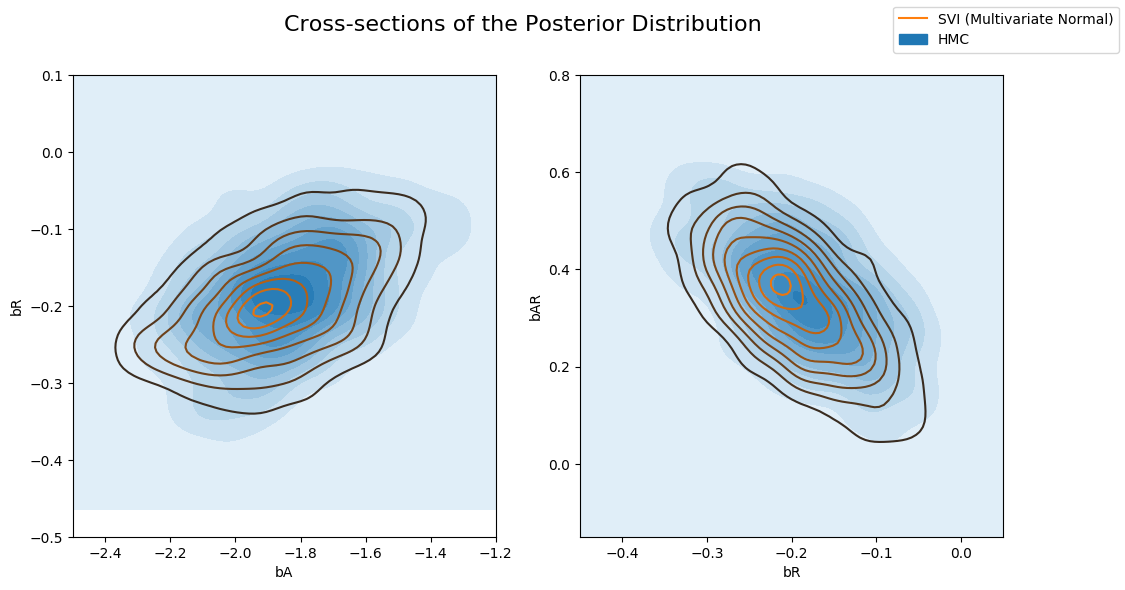

In [19]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
fig.suptitle("Cross-sections of the Posterior Distribution", fontsize=16)

sns.kdeplot(hmc_samples["bA"], hmc_samples["bR"], ax=axs[0], shade=True, label="HMC")
sns.kdeplot(svi_mvn_samples["bA"], svi_mvn_samples["bR"], ax=axs[0], label="SVI (Multivariate Normal)")
axs[0].set(xlabel="bA", ylabel="bR", xlim=(-2.5, -1.2), ylim=(-0.5, 0.1))

sns.kdeplot(hmc_samples["bR"], hmc_samples["bAR"], ax=axs[1], shade=True, label="HMC")
sns.kdeplot(svi_mvn_samples["bR"], svi_mvn_samples["bAR"], ax=axs[1], label="SVI (Multivariate Normal)")
axs[1].set(xlabel="bR", ylabel="bAR", xlim=(-0.45, 0.05), ylim=(-0.15, 0.8))

handles, labels = axs[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right');